In [1]:
import os
from typing import Dict, List, Tuple

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import tensorboard
import torch
from lightning.pytorch.callbacks import (
    LearningRateMonitor,
    ModelCheckpoint,
    ModelSummary,
)
from PIL import Image
from rich import print
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%load_ext rich
%load_ext tensorboard

# Set random seed for reproducibility
seed = 42
L.seed_everything(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Set data directory
DATA_DIR = os.path.join(os.getcwd(), "data")

c:\Users\Lakshya Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Seed set to 42


Device: cuda

## Load and preprocess the dataset

The CIFAR datasets consist of 32x32 color images with 10 classes. In this section, the following steps are performed:
- Load the CIFAR-10 dataset
- Visualize some images from the training set
- Calculate the mean and standard deviation of all channels
- Apply data augmentation to the training set by randomly flipping the images horizontally and randomly cropping the images
- Normalize the images using the mean and standard deviation
- Create a PyTorch dataset and dataloader for the training and test set


In [2]:
label_classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [3]:
train_dataset = CIFAR10(DATA_DIR, train=True, download=True)
train_dataset


Files already downloaded and verified



Dataset CIFAR10
    Number of datapoints: 50000
    Root location: e:\McGill MMA\Notes\Summer 2024\MGSC 695\Assignments\Assignment 1\data
    Split: Train

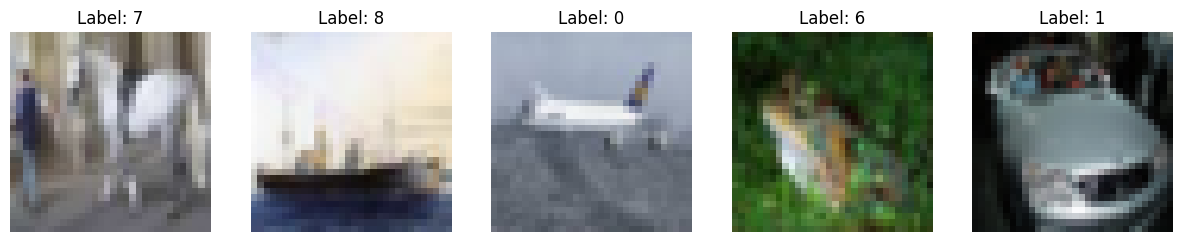

In [4]:
# Display some images randomly
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(np.random.choice(len(train_dataset), 5, replace=False)):
    ax[i].imshow(train_dataset[idx][0])
    ax[i].set_title(f"Label: {train_dataset[idx][1]}")
    ax[i].axis("off")

plt.show()


In [5]:
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0, 1, 2))
print(f"Data mean: {DATA_MEANS}, Data std: {DATA_STD}")


Data mean: [0.49139968 0.48215841 0.44653091], Data std: [0.24703223 0.24348513 0.26158784]

In [6]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEANS, DATA_STD),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEANS, DATA_STD),
    ]
)


In [7]:
# Read the CIFAR-10 dataset and split it into train and validation sets

train_dataset = CIFAR10(DATA_DIR, train=True, download=True, transform=train_transform)
val_dataset = CIFAR10(DATA_DIR, train=True, download=True, transform=test_transform)
test_dataset = CIFAR10(DATA_DIR, train=False, download=True, transform=test_transform)

# Generate validation set without any data leakage while applying different transformations
L.seed_everything(seed)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
L.seed_everything(seed)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Seed set to 42
Seed set to 42


In [8]:
BATCH_SIZE = 128
# Generate data loaders
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
    persistent_workers=True,
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
    persistent_workers=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

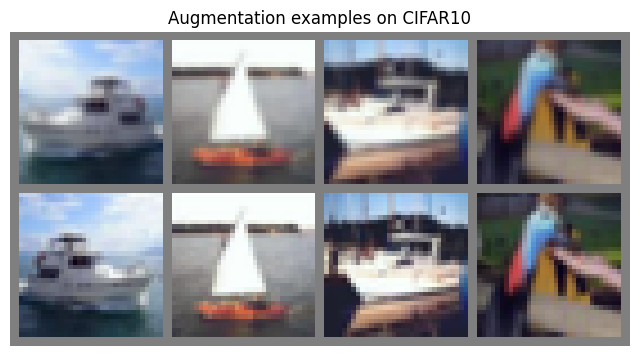

In [9]:
NUM_IMAGES = 4
RNG_IDX = np.random.choice(len(train_dataset), NUM_IMAGES)
images = [train_dataset[idx][0] for idx in RNG_IDX]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in RNG_IDX]
orig_images = [test_transform(img) for img in orig_images]

img_grid = make_grid(
    torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5
)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()


## Build the ResNet model

The convolutional neural network architecture used in this notebook is inspired by the ResNet architecture from the paper ["Deep Residual Learning for Image Recognition" by He et al. (2015)](https://arxiv.org/pdf/1512.03385).

The ResNet architecture consists of a series of residual blocks, which are composed of convolutional layers, batch normalization, and ReLU activation functions. The residual blocks are connected by skip connections, which allow the network to learn residual functions instead of the original mapping. This helps to mitigate the vanishing gradient problem and enables the training of very deep networks. At the end of the network, a global average pooling layer and a fully connected layer are used to produce the final output that represents the class probabilities.

In essence, instead of learning the desired output, the network learns the residual between the desired output and the current output. 

### Architecture
The ResNet architecture used in this notebook consists of the following components:
- Initial convolutional layer with 16 output channels and kernel size 1x1, followed by batch normalization
- A series of residual blocks with feature map sizes of {32, 16, 8}
- A final output layer that consists of global average pooling and a fully connected layer with 10 output units (one for each class)

### Residual block
The residual block consists of the following components:
- Convolutional layer with kernel size 3x3 and padding 1, with an optional stride of 2 for downsampling
- Batch normalization
- ReLU activation function
- Convolutional layer with kernel size 3x3 and padding 1 and a stride of 1
- Batch normalization
- Skip connection to add the input to the output of the second convolutional layer

The ResNet model is implemented using PyTorch and is defined in the `ResNet` class.

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, first_stride: int = 1):
        super().__init__()

        self.left = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=first_stride,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=out_channels),
        )

        if first_stride > 1:
            self.right = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=first_stride,
                    bias=False,
                ),
                nn.BatchNorm2d(num_features=out_channels),
            )
        else:
            assert (
                in_channels == out_channels
            ), "in_channels must be equal to out_channels"
            self.right = nn.Identity()

        self.relu = nn.ReLU()

    def forward(self, x):
        left = self.left(x)
        right = self.right(x)
        return self.relu(left + right)


In [11]:
class BlockGroup(nn.Module):
    def __init__(
        self, n_blocks: int, in_channels: int, out_channels: int, first_stride: int = 1
    ):
        super().__init__()
        self.blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels, first_stride=first_stride),
            *[ResidualBlock(out_channels, out_channels) for _ in range(n_blocks - 1)],
        )

    def forward(self, x):
        """
        Compute the forward pass.

        x: shape (batch, in_feats, height, width)

        Return: shape (batch, out_feats, height / first_stride, width / first_stride)
        """
        return self.blocks(x)

In [12]:
class ResNet(nn.Module):
    def __init__(
        self,
        n_blocks_per_group: List[int],
        out_features_per_group: List[int],
        first_strides_per_group: List[int],
        n_classes: int = 10,
        in_feats0: int = 16,
    ):
        super().__init__()

        self.in_feats0 = in_feats0
        self.n_classes = n_classes
        self.n_blocks_per_group = n_blocks_per_group
        self.out_features_per_group = out_features_per_group
        self.first_strides_per_group = first_strides_per_group

        self.in_layers = nn.Sequential(
            nn.Conv2d(3, in_feats0, kernel_size=1, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=in_feats0),
        )

        all_in_feats = [in_feats0] + out_features_per_group[:-1]

        self.residual_layers = nn.Sequential(
            *(
                BlockGroup(*args)
                for args in zip(
                    n_blocks_per_group,
                    all_in_feats,
                    out_features_per_group,
                    first_strides_per_group,
                )
            )
        )

        self.out_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(out_features_per_group[-1], n_classes),
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.out_layers(self.residual_layers(self.in_layers(x)))
        return x


## Train the CNN model

To train the ResNet model, PyTorch Lightning is used to simplify the training process. PyTorch Lightning provides a high-level interface for PyTorch that abstracts away the training loop, validation loop, and other boilerplate code. This makes it easier to train models and experiment with different architectures and hyperparameters.

The training process consists of the following steps:
- Initialize the ResNet model with the specified hyperparameters (e.g., number of residual blocks, feature map sizes, etc.)
- Define the loss function (cross-entropy loss)
- Define the optimizer, associated hyperparameters (e.g., learning rate, weight decay) and learning rate scheduler
- Log the training, validation, and test accuracy using TensorBoard
- Log the validation images and predictions using TensorBoard for visualization
- Save the best model based on the validation accuracy
- Monitor the learning rate and log it using TensorBoard

The model is trained with 32-layers, a batch size of 128, a learning rate of 0.1, a weight decay of 1e-4, a momentum of 0.9 and a learning rate scheduler that reduces the learning rate on a plateau. The model is trained for 50 epochs, and the best model based on the validation accuracy is saved. The hyperparameters are chosen based on the original paper's recommendations for training ResNet on CIFAR-10.

In [ ]:
class CIFARModule(L.LightningModule):
    def __init__(
        self,
        model_hparams: Dict,
        optimizer_name: str,
        optimizer_hparams: Dict,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.model = ResNet(**model_hparams)

        self.loss_fn = nn.CrossEntropyLoss()

        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        if self.hparams.optimizer_name == "Adam":
            optimizer = torch.optim.AdamW(
                self.parameters(), **self.hparams.optimizer_hparams
            )

        elif self.hparams.optimizer_name == "SGD":
            optimizer = torch.optim.SGD(
                self.parameters(), **self.hparams.optimizer_hparams
            )

        else:
            assert False, f"Unknown optimizer: {self.hparams.optimizer_name}"

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="max",
        )

        return {
            "optimizer": optimizer,
            "scheduler": scheduler,
            "monitor": "val_acc",
        }

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_fn(preds, labels)

        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(
            "train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_fn(preds, labels)

        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(
            "val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        if batch_idx == 1:
            indices = np.random.choice(len(imgs), 3, replace=False)

            fig, axs = plt.subplots(1, 3, figsize=(9, 3))
            fig.suptitle("Sample Validation Images with Predictions")

            for idx, ax in zip(indices, axs.flatten()):
                img = (
                    transforms.Resize((224, 224))(imgs[idx])
                    .permute(1, 2, 0)
                    .cpu()
                    .numpy()
                )
                true_label = labels[idx].item()
                predicted_label = preds.argmax(dim=-1)[idx].item()

                ax.imshow(np.clip(img, 0, 1), interpolation="nearest")
                ax.set_title(
                    f"True: {label_classes[true_label]}, Pred: {label_classes[predicted_label]}"
                )
                ax.axis("off")

            # Log the figure
            self.logger.experiment.add_figure(
                "Validation Images", fig, self.current_epoch
            )
            plt.close(fig)

        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_fn(preds, labels)

        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(
            "test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        self.log(
            "test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True
        )

        return loss

In [14]:
model = CIFARModule(
    model_hparams={
        "n_blocks_per_group": [5, 5, 5],
        "out_features_per_group": [16, 32, 64],
        "first_strides_per_group": [1, 2, 2],
        "n_classes": 10,
    },
    optimizer_name="SGD",
    optimizer_hparams={"lr": 0.1, "weight_decay": 1e-4, "momentum": 0.9},
)

# 6n + 2 layers
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

Total number of parameters: 466522

In [96]:
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=50,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
        LearningRateMonitor(
            logging_interval="epoch", log_momentum=True, log_weight_decay=True
        ),
    ],
)

trainer.logger._log_graph = True
trainer.logger._default_hp_metric = None

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [97]:
L.seed_everything(42)
trainer.fit(model, train_loader, val_loader)

Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | In sizes       | Out sizes
--------------------------------------------------------------------------
0 | model   | ResNet           | 466 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_fn | CrossEntropyLoss | 0      | ?              | ?        
--------------------------------------------------------------------------
466 K     Trainable params
0         Non-trainable params
466 K     Total params
1.866     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluating the trained model

The ResNet-32 model is evaluated on the validation and test sets to measure its performance. The accuracy on the test set is reported as the final evaluation metric.

In [22]:
model = CIFARModule.load_from_checkpoint(
    checkpoint_path="./lightning_logs/version_11/checkpoints/epoch=49-step=17550.ckpt"
)
model.eval()

trainer = L.Trainer(
    accelerator="auto",
    logger=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
val_result = trainer.test(model, dataloaders=val_loader, verbose=True)

print(f"Validation accuracy: {val_result[0]['test_acc']:.4f}")
print(f"Validation loss: {val_result[0]['test_loss']:.4f}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8715999722480774     │
│         test_loss         │    0.3946439325809479     │
└───────────────────────────┴───────────────────────────┘

Validation accuracy: 0.8716

Validation loss: 0.3946

In [24]:
test_result = trainer.test(model, dataloaders=test_loader, verbose=True)

print(f"Test accuracy: {test_result[0]['test_acc']:.4f}")
print(f"Test loss: {test_result[0]['test_loss']:.4f}")


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8676999807357788     │
│         test_loss         │    0.4166187345981598     │
└───────────────────────────┴───────────────────────────┘

Test accuracy: 0.8677

Test loss: 0.4166

## Generate a prediction

Finally, the trained model is used to generate predictions on a sample image from the test set. The predicted class label and the corresponding class probability are displayed.

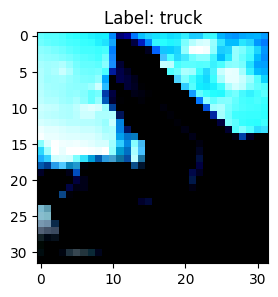

Predicted: truck | Probability: 0.9083

In [26]:
test_idx = 50
test_img, label = (
    test_dataset[test_idx][0].unsqueeze(0),
    test_dataset[test_idx][1],
)

plt.figure(figsize=(3, 3))

plt.imshow(test_img.squeeze().permute(1, 2, 0).cpu().numpy().clip(0, 1))
plt.title(f"Label: {label_classes[label]}")
plt.show()

pred = model(test_img)
print(
    f"Predicted: {label_classes[pred.argmax(dim=-1).item()]} | Probability: {pred.softmax(dim=-1).max().item():.4f}"
)